## Sentiment Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [4]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,classification_report
from scikitplot.metrics import plot_confusion_matrix

### Data Exploration

In [5]:
df_train = pd.read_csv("../data/raw/train.txt",delimiter=';',names=['text','label'])
df_val = pd.read_csv("../data/raw/val.txt",delimiter=';',names=['text','label'])

Since we are using Cross validation, we will merge train and validation datasets, and use a random subset as a validation set for every cv round.

In [6]:
df_train = pd.concat([df_train,df_val])
df_train.reset_index(inplace=True,drop=True)

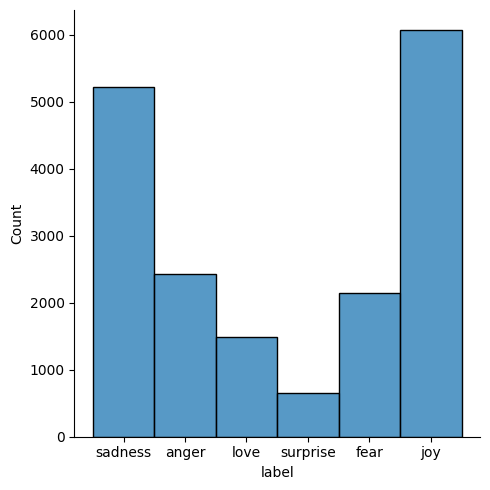

In [7]:
sns.displot(df_train['label'])

To make our work easier, we will redice the class count down to 2, positive or negative sentiment. 

In [8]:
def custom_encoder(df):
    df.replace(to_replace ="surprise", value =1, inplace=True)
    df.replace(to_replace ="love", value =1, inplace=True)
    df.replace(to_replace ="joy", value =1, inplace=True)
    df.replace(to_replace ="fear", value =0, inplace=True)
    df.replace(to_replace ="anger", value =0, inplace=True)
    df.replace(to_replace ="sadness", value =0, inplace=True)

In [9]:
custom_encoder(df_train['label'])

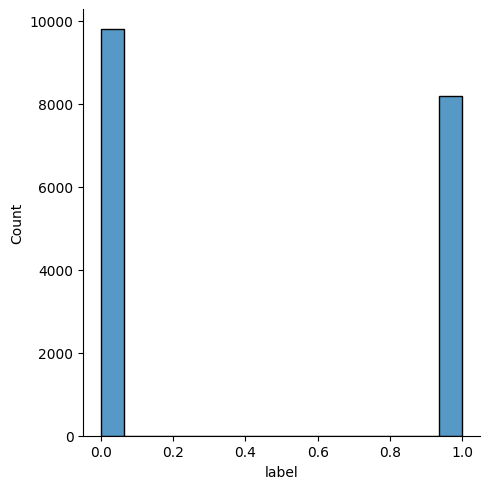

In [10]:
sns.displot(df_train['label'])

### Pre-processing

In [11]:
lm = WordNetLemmatizer()

In [12]:
nltk.download('stopwords')
nltk.download('wordnet')

def text_transformation(df_col):
    corpus = []
    for item in df_col:
        new_item = re.sub('[^a-zA-Z]',' ',str(item))
        new_item = new_item.lower()
        new_item = new_item.split()
        new_item = [lm.lemmatize(word) for word in new_item if word not in set(stopwords.words('english'))]
        corpus.append(' '.join(str(x) for x in new_item))
    return corpus

[nltk_data] Downloading package stopwords to /home/elie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/elie/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
corpus = text_transformation(df_train['text'])

In [14]:
cv = CountVectorizer(ngram_range=(1,2))
traindata = cv.fit_transform(corpus)
X = traindata
y = df_train.label

### Training

In [29]:
parameters = {'max_features': ['sqrt'],
             'n_estimators': [50],
             'max_depth': [None],
             'min_samples_split': [5],
             'min_samples_leaf': [1],
             'bootstrap': [True]}

In [30]:
grid_search = GridSearchCV(RandomForestClassifier(),parameters,cv=2,return_train_score=True,n_jobs=-1,verbose=4)
grid_search.fit(X,y)
grid_search.best_params_

Fitting 2 folds for each of 1 candidates, totalling 2 fits


{'bootstrap': True,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 50}

In [44]:
grid_search.best_score_

0.9442222222222223

In [46]:
grid_search.best_estimator_

RandomForestClassifier(min_samples_split=5, n_estimators=50)

### Model Evaluation

In [31]:
rfc = RandomForestClassifier(max_features=grid_search.best_params_['max_features'],
                                      max_depth=grid_search.best_params_['max_depth'],
                                      n_estimators=grid_search.best_params_['n_estimators'],
                                      min_samples_split=grid_search.best_params_['min_samples_split'],
                                      min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
                                      bootstrap=grid_search.best_params_['bootstrap'])
rfc.fit(X,y)

RandomForestClassifier(min_samples_split=5, n_estimators=50)

In [32]:
test_df = pd.read_csv('../data/raw/test.txt',delimiter=';',names=['text','label'])

In [33]:
X_test,y_test = test_df.text,test_df.label
#encode the labels into two classes , 0 and 1
test_df = custom_encoder(y_test)
#pre-processing of text
test_corpus = text_transformation(X_test)
#convert text data into vectors
testdata = cv.transform(test_corpus)
#predict the target
predictions = rfc.predict(testdata)

Accuracy_score:  0.961
Precision_score:  0.9616228070175439
Recall_score:  0.9532608695652174
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1080
           1       0.96      0.95      0.96       920

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



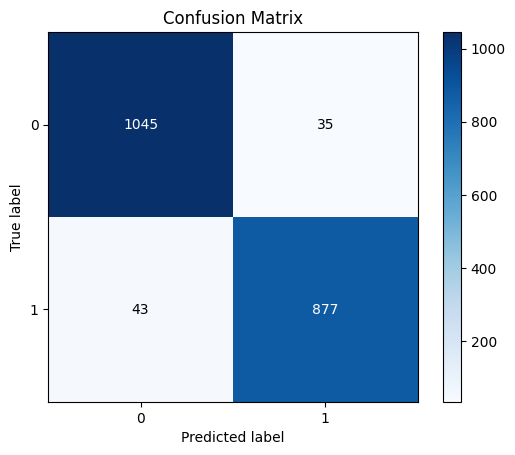

In [35]:
plot_confusion_matrix(y_test,predictions)
acc_score = accuracy_score(y_test,predictions)
pre_score = precision_score(y_test,predictions)
rec_score = recall_score(y_test,predictions)
print('Accuracy_score: ',acc_score)
print('Precision_score: ',pre_score)
print('Recall_score: ',rec_score)
print("-"*50)
cr = classification_report(y_test,predictions)
print(cr)

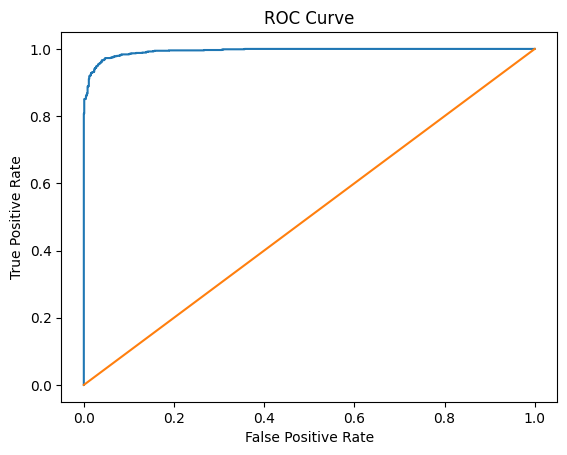

In [36]:
predictions_probability = rfc.predict_proba(testdata)
fpr,tpr,thresholds = roc_curve(y_test,predictions_probability[:,1])
plt.plot(fpr,tpr)
plt.plot([0,1])
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

### Inference

In [37]:
def expression_check(prediction_input):
    if prediction_input == 0:
        print("Input statement has Negative Sentiment.")
    elif prediction_input == 1:
        print("Input statement has Positive Sentiment.")
    else:
        print("Invalid Statement.")

In [38]:
# function to take the input statement and perform the same transformations we did earlier
def sentiment_predictor(input):
    input = text_transformation(input)
    transformed_input = cv.transform(input)
    prediction = rfc.predict(transformed_input)
    expression_check(prediction)

In [41]:
input1 = ["Sometimes I just want to punch someone in the face."]
input2 = ["I am so happy."]

In [42]:
sentiment_predictor(input1)
sentiment_predictor(input2)

Input statement has Negative Sentiment.
Input statement has Positive Sentiment.
[CV 2/2] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=(train=0.999, test=0.944) total time=  34.0s
[CV 1/2] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=(train=0.999, test=0.945) total time=  34.4s


In [47]:
input = text_transformation(["I am so happy.", "So Happy"])
transformed_input = cv.transform(input)
prediction = rfc.predict(transformed_input)

In [49]:
type(prediction)

numpy.ndarray